Use previous test, create noise and sine wave, create combined hmm,
Then change the SNR between the two and make sure it is working correctly

In [3]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [7]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils
reload(utils)
import librosa
from spafe.utils import vis
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=60)

<Figure size 240x240 with 0 Axes>

<Figure size 240x240 with 0 Axes>

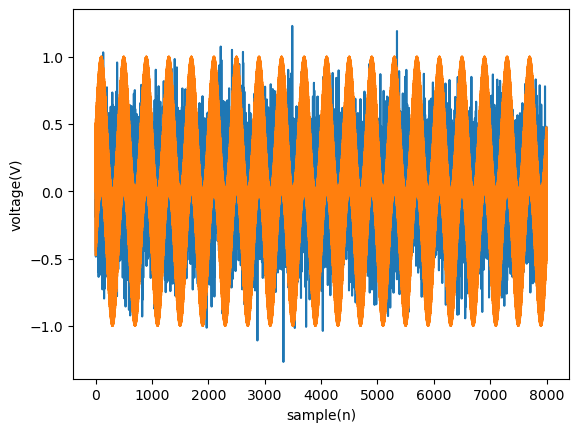

In [20]:
Fs = 8000
f1 = 20 # hz
f2 = 2000
sample = 8000
x = np.arange(sample)
noise = np.random.normal(0, np.sqrt(0.1), sample)
s1 = np.sin(2 * np.pi * f1 * x / Fs) + np.sin(2 * np.pi * f2 * x / Fs)
s1 = librosa.util.normalize(s1)
s2 = noise #librosa.util.normalize(noise)
plt.plot(x, s2)
plt.plot(x, s1)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

In [33]:
# power and SNR
ap = utils.periodic_power(s2, 500, 250)
# plt.plot(ap)
noise_average_power = 0.10
signal_average_power = 0.25
snr = signal_average_power / noise_average_power
snr_db = 10 * np.log10(snr)
print(snr)

2.5


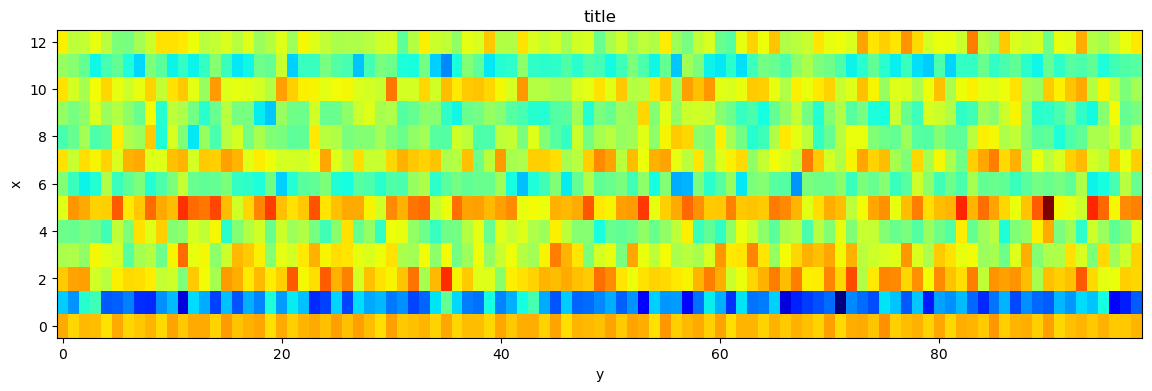

-1308.1924822756066 -6938.941421450128 -37184.922610503374


In [42]:
s1_feat = mfcc(signal=s1, samplerate=8000, appendEnergy=True, lowfreq=0, highfreq=3000, winfunc=np.hamming, preemph=0, ceplifter=0)
s1_hmm = hmm.GaussianHMM(1)
s1_hmm.fit(s1_feat)
s1_hmm_sampled, _ = s1_hmm.sample(100)
# vis.show_features(s1_hmm_sampled, 'title', 'x', 'y')

s2_feat = mfcc(signal=s2, samplerate=8000, appendEnergy=True, lowfreq=0, highfreq=3000, winfunc=np.hamming, preemph=0, ceplifter=0)
s2_hmm = hmm.GaussianHMM(1)
s2_hmm.fit(s2_feat)
s2_hmm_sampled, _ = s2_hmm.sample(100)
# vis.show_features(s2_hmm_sampled, 'title', 'x', 'y')

s3 = s1 + s2
s3_feat = mfcc(signal=s3, samplerate=8000, appendEnergy=True, lowfreq=0, highfreq=3000, winfunc=np.hamming, preemph=0, ceplifter=0)
vis.show_features(s3_feat[:100,:], 'title','x', 'y')

from processing import process_method_base
from classifiers.fhmm import classifier_fhmm
import feature_extraction.fe_spafe.fe_spafe as fe_spafe

fe_method = fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC)
process_method = process_method_base.ProcessMethodBase(snr_db=40, reverb=False)
classifier = classifier_fhmm.ClassifierFHMM(fe_method, process_method)
classifier.hmms = {
    's1': s1_hmm
}
classifier.noise_hmm = s2_hmm
classifier.snr_noise = 6
classifier.adapt_speaker_models()
combined_hmm = classifier.hmms['s1']

s3_hmm = hmm.GaussianHMM(1)
s3_hmm.fit(s3_feat)
print(s3_hmm.score(s3_feat), combined_hmm.score(s3_feat), s1_hmm.score(s3_feat))

<StemContainer object of 3 artists>

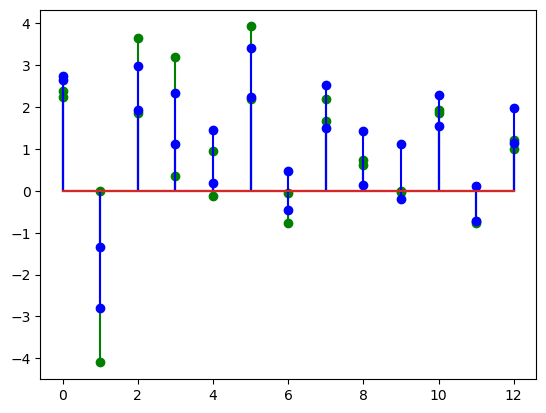

In [43]:

combined_hmm_samples, _ = combined_hmm.sample(50)
s3_feat_means = np.mean(s3_feat, axis=0)
s3_feat_var = np.square(np.std(s3_feat, axis=0))
combined_hmm_features_means = np.mean(combined_hmm_samples, axis=0)
combined_hmm_features_var = np.square(np.std(combined_hmm_samples, axis=0))

means_x = np.arange(len(s3_feat_means))
plt.stem(means_x, combined_hmm_features_means + combined_hmm_features_var, linefmt='g', markerfmt='go', label="sim")
plt.stem(means_x, combined_hmm_features_means - combined_hmm_features_var, linefmt='g', markerfmt='go', label="sim")
plt.stem(means_x, s3_feat_means + s3_feat_var, linefmt='b', markerfmt='bo', label="real")
plt.stem(means_x, s3_feat_means - s3_feat_var, linefmt='b', markerfmt='bo', label="real")